# Some plots for the exploratory analysis

In [1]:
library(ggplot2)
library(dplyr)
library(data.table)
library(ismev)
library(evd)
library(extRemes)
library(GGally)
library(maxstablePCA)
library(lubridate)
library(ggmap)
library(sf)
library(osmdata)
library(ggspatial)
library(rnaturalearth)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following object is masked from ‘package:evd’:

    mrlplot


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minut

In [2]:
data(elbe)
dat <- elbe$train$raw
summer_blockmax_dat <- elbe$train$blockmax
info_dat <- elbe$info

test <- elbe$test$raw

In [3]:
info_dat

name,lat,lon,river,next_downstream
<chr>,<dbl>,<dbl>,<chr>,<chr>
Aken,51.8582,12.0522,Elbe,Magdeburg
Bad_Dueben,51.5906,12.5805,Mulde,Aken
Calbe,51.8958,11.7854,Saale,Magdeburg
Dresden,51.0559,13.7379,Elbe,Torgau
Havelberg_Stadt,52.8245,12.0804,Havel,Wittenberge
Loeben,51.7685,13.0827,schwarze Elster,Wittenberg
Magdeburg,52.1515,11.6700,Elbe,Tangermuende
Neu_Darchau,53.2347,10.8933,Elbe,
Schoena,50.8951,14.2245,Elbe,Dresden


In [4]:
summary(dat)

     date                Aken          Bad_Dueben          Calbe      
 Length:9865        Min.   : 119.0   Min.   :  11.90   Min.   : 35.4  
 Class :character   1st Qu.: 212.0   1st Qu.:  27.20   1st Qu.: 58.5  
 Mode  :character   Median : 316.0   Median :  45.20   Median : 84.5  
                    Mean   : 412.9   Mean   :  63.57   Mean   :110.9  
                    3rd Qu.: 507.0   3rd Qu.:  77.40   3rd Qu.:134.0  
                    Max.   :3960.0   Max.   :2010.00   Max.   :730.0  
                    NA's   :1828     NA's   :2101      NA's   :2085   
    Dresden       Havelberg_Stadt       Loeben         Magdeburg     
 Min.   :  84.7   Min.   :-388.00   Min.   :  0.95   Min.   : 179.0  
 1st Qu.: 159.0   1st Qu.:  45.30   1st Qu.:  6.44   1st Qu.: 277.0  
 Median : 235.0   Median :  80.80   Median : 11.30   Median : 387.0  
 Mean   : 319.9   Mean   :  86.12   Mean   : 15.15   Mean   : 525.5  
 3rd Qu.: 389.0   3rd Qu.: 118.00   3rd Qu.: 18.90   3rd Qu.: 641.0  
 Max.   :450

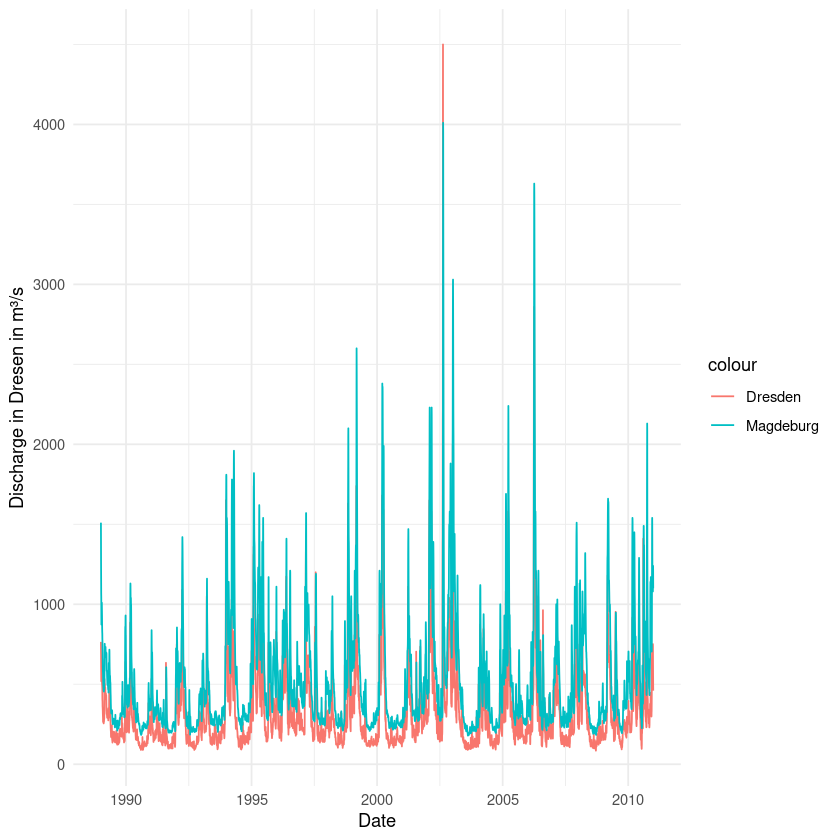

In [5]:
tsplot <- ggplot(
    data = dat %>% select(c("date", "Dresden", "Magdeburg")) %>% na.omit(), 
    aes(x = as.Date(date), y = Dresden, color = "Dresden")
) + 
geom_line() +
geom_line(aes(x = as.Date(date), y = Magdeburg, color = "Magdeburg")) +
xlab("Date") + 
ylab("Discharge in Dresen in m³/s") + 
theme_minimal()

tsplot

In [6]:
ggsave("tsplot.png", plot = tsplot, width = 18, height = 8)

In [7]:
data(elbe)
dat <- elbe$train$raw
summer_blockmax_dat <- elbe$train$blockmax
summer_blockmax_dat_test <- elbe$test$blockmax

train <- elbe$train$raw 
test <- elbe$test$raw

train$date <- as.Date(train$date)
test$date <- as.Date(test$date)

train_summer <-  train %>% filter(month(date) >= 6, month(date) <= 9)
test_summer <-  test%>% filter(month(date) >= 6, month(date) <= 9)

train_summer_declustered <- train_summer %>% 
group_by(year(date), month(date), day(date) > 15) %>% 
summarize_all(max) %>% 
na.omit()

test_summer_declustered <- test_summer %>% 
group_by(year(date), month(date), day(date) > 15) %>% 
summarize_all(max) %>% 
na.omit()

In [8]:
plotdat <- transform_unitfrechet(train_summer_declustered[, 5:17])
plotdat <- data.frame(plotdat)

In [9]:
p <- ggpairs(plotdat, 
        columns = c(3,4,7,9), 
        upper =  list(continuous = "points")
) + theme_minimal()

In [10]:
ggsave("elbe_pairs.png", p)

Saving 7 x 7 in image


# Creating the plot for the river network

In [11]:
sf_basin <- read_sf("./data/geoinfo_rivernetwork/mrb_basins.json")
sf_river <- read_sf("./data/geoinfo_rivernetwork/mrb_rivers.json")
sf_river2 <- read_sf("./data/geoinfo_rivernetwork/mrb_rivnets_Q08_09.json")
sf_river3 <- read_sf("./data/geoinfo_rivernetwork/mrb_rivnets_Q09_10.json")

station_info <- elbe$info

rivercolor = "#3DE6FF"

In [12]:
# Bounding box roughly covering the Elbe basin
bb_elbe <- matrix(c(8.5, 50.0,   # lower left corner (lon, lat)
                    15.5, 54.0), # upper right corner (lon, lat)
                  ncol = 2, byrow = TRUE,
                  dimnames = list(c("x","y"), c("min","max")))

# Germany and Czech Republic from Natural Earth
countries <- ne_countries(country = c("Germany", "Czechia"), returnclass = "sf")

cities_sf <- st_as_sf(station_info, coords = c("lon", "lat"), crs = 4326)
st_transfcities_sf <- st_as_sf(cities_sf, coords = c("lon", "lat"), crs = 4326)

Zoom: 7



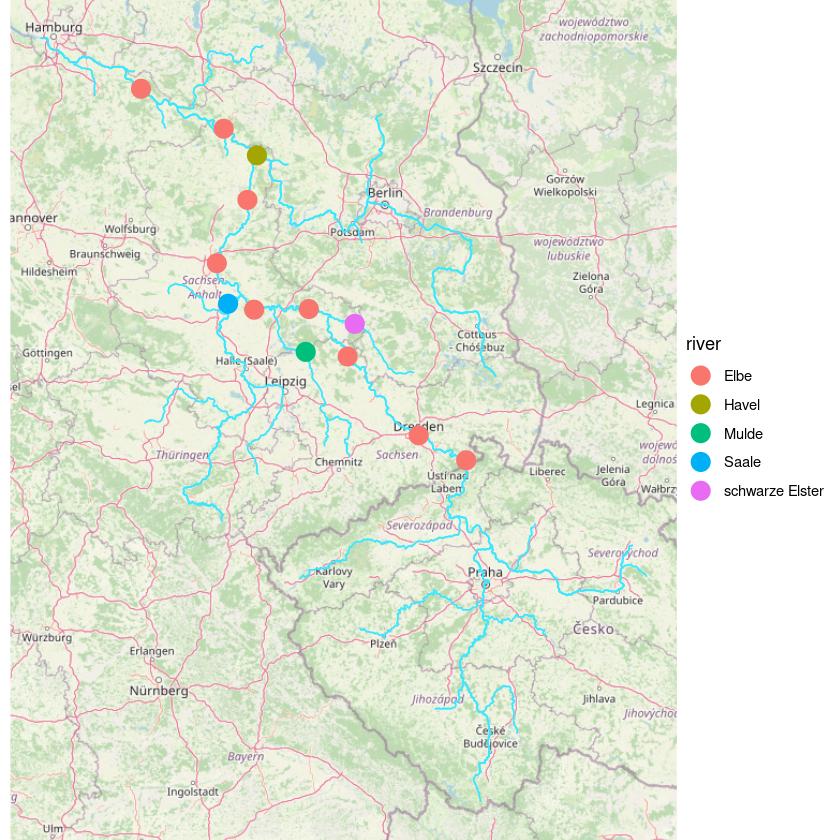

In [13]:
p <- ggplot() +
annotation_map_tile(type = "osm", zoom = 7) +   # OSM basemap
geom_sf(data = sf_river, fill = "#69b3a2", color = rivercolor, inherit.aes = F) +
geom_sf(data = sf_river2, fill = "#69b3a2", color = rivercolor, inherit.aes = F) +
geom_sf(data = sf_river3, fill = "#69b3a2", color = rivercolor, inherit.aes = F) +
geom_sf(data = cities_sf, aes(color = river), size = 5) +   # points
theme_void()

p

In [14]:
ggsave("stations_map.png", p)

Saving 7 x 7 in image
Zoom: 7

